In [1]:
import pymongo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient

In [2]:
client = MongoClient('localhost', 27017)
db = client["delhi"]

In [77]:
tiles = list(db["hex-tiles2"].find())

In [3]:
dtimes = list(db["drivingTime"].find())

In [4]:
len(dtimes)

1739618

## Finding the distribution of road density 

In [79]:
hex_tiles = pd.DataFrame.from_dict(tiles)

In [80]:
hex_tiles.columns

Index(['_id', 'geometry', 'properties', 'type'], dtype='object')

Looking to find what is the lower quartile which I can ignore

In [58]:
df = pd.DataFrame([],columns=["count"])
for tile in tiles:
    if 'roadCount' in tile["properties"]:
        df = df.append(pd.DataFrame([tile["properties"]["roadCount"]],columns=["count"]))

In [92]:
df.quantile([0.25,0.5,0.75,.9])

,count
0.25,39.0
0.50,96.0
0.75,208.5
0.90,336.6


In [90]:
df.plot.scatter()
plt.show()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

In [145]:
df[df["count"]>=7].shape

(493, 1)

## Finding the population travelling to different distances 

Looking to find the quartile which I can ignore

In [4]:
trans = pd.read_excel("data/mode_of_transport_india.xls")

In [27]:
pd.options.display.max_colwidth=-1
trans[236:237]

,,B-28 'OTHER WORKERS' BY DISTANCE FROM RESIDENCE TO PLACE OF WORK AND MODE OF TRAVEL TO PLACE OF WORK,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30
Total,NCT OF DELHI,All Modes,5332324,4550458,781866,843162,670490,172672,849934,718690,131244,...,44629,161097,139728,21369,40550,35914,4636,37133,32027,5106


In [36]:
dd = pd.DataFrame([[838188, 1275681, 956043, 777063, 324689, 152613, 39097]],columns=["0-1","2-5","6-10","11-20","21-30","31-50","51+"])
dd

,0-1,2-5,6-10,11-20,21-30,31-50,51+
0,838188,1275681,956043,777063,324689,152613,39097


In [51]:
dd.plot()

/Users/aseemaggarwal/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


In [33]:
dd = pd.DataFrame([838188, 1275681, 956043, 777063, 324689, 152613, 39097],columns=["d"])
dd

,d
0,838188
1,1275681
2,956043
3,777063
4,324689
5,152613
6,39097


In [32]:
dd.quantile([0.25,0.5,0.8,0.99])

,d
0.25,238651.00
0.50,777063.00
0.80,932472.00
0.99,1256502.72


In [70]:
plt.figure()
plt.hist(dd)

TypeError: 'Figure' object is not callable

# Driving Times

In [5]:
df = pd.DataFrame.from_dict(dtimes)

In [6]:
df.shape

(1739618, 13)

In [7]:
df.columns

Index(['_id', 'dist', 'dur', 'durTr', 'enAdd', 'enLoc', 'neDist', 'stAdd',
       'stLoc', 'steps', 'tEn', 'tFr', 'timestamp'],
      dtype='object')

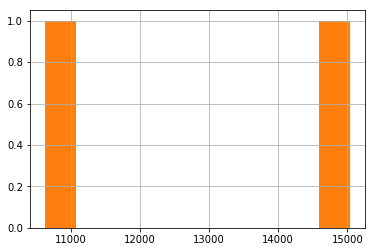

In [13]:
def thresh(val):
    if val < 1:
        return 100
    else:
        return val*100

In [14]:
df["excessRatio"] = (df["durTr"]/df["dur"])

In [15]:
df["excessRatio"] = df["excessRatio"].apply(thresh)

In [16]:
df["excessRatio"].describe()

count    1.739618e+06
mean     1.373000e+02
std      2.898468e+01
min      1.000000e+02
25%      1.105788e+02
50%      1.357787e+02
75%      1.567706e+02
max      3.464203e+02
Name: excessRatio, dtype: float64

In [22]:
df["excessRatio"].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,.99,.999,.9999])

0.1000    100.155428
0.2000    106.366090
0.3000    115.982619
0.4000    127.123994
0.5000    135.778747
0.6000    143.778383
0.7000    152.166925
0.8000    161.948420
0.9000    175.842359
0.9900    214.636351
0.9990    246.786436
0.9999    278.050889
Name: excessRatio, dtype: float64

### Converting the timestamp to actual timepoint

In [13]:
df["timestamp"] = df["timestamp"]*1000

In [14]:
def week_time(ts):
    date = pd.to_datetime(ts, unit='ms')
    return (str(date.dayofweek) + "_"+str(date.hour+5).zfill(2) + "_"  +str(date.minute+30))

In [15]:
df["week_time"] = df["timestamp"].apply(week_time)

### Plotting the variation in total excess time across timepoints 

In [16]:
def plot_excesstime(dd): 
    grps_time = dd.groupby(df["week_time"])
    timepoints_sum = grps_time.sum()
    pltt = timepoints_sum.plot(kind="bar",sort_columns=True)
    return pltt

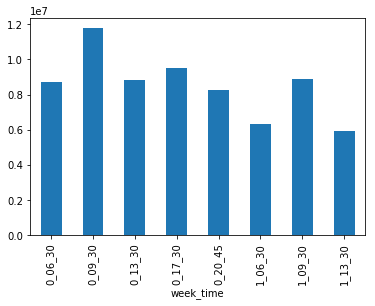

In [17]:
plt1 = plot_excesstime(df["excessRatio"])
plt.show()

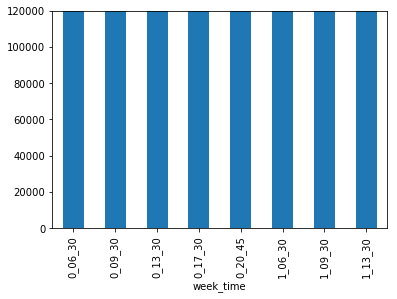

In [18]:
plt2 = plot_excesstime(df[df["dist"]>25000]["excessRatio"])
plt2.set_ylim(0,120000)
plt.show()

In [19]:
df["distCat"] = pd.cut(df["dist"], [0,4000,8000,12000,16000,20000,24000,28000,32000,50000])

### Finding total time wasted by timepoint and distance

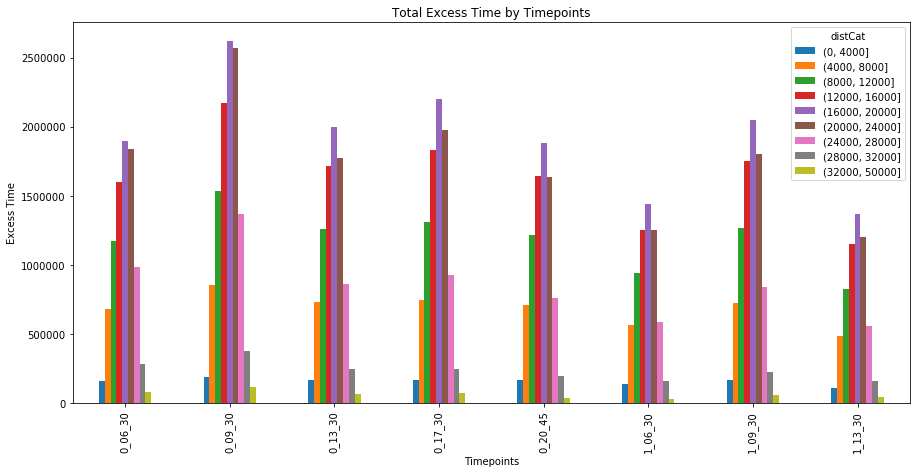

In [20]:
grps_time = df.groupby(["week_time","distCat"])["excessRatio"].sum()
my_plot = grps_time.unstack().plot(kind='bar',title="Total Excess Time by Timepoints",figsize=(15, 7))
my_plot.set_xlabel("Timepoints")
my_plot.set_ylabel("Excess Time")
plt.show()

### Finding average time wasted by timepoint and distance

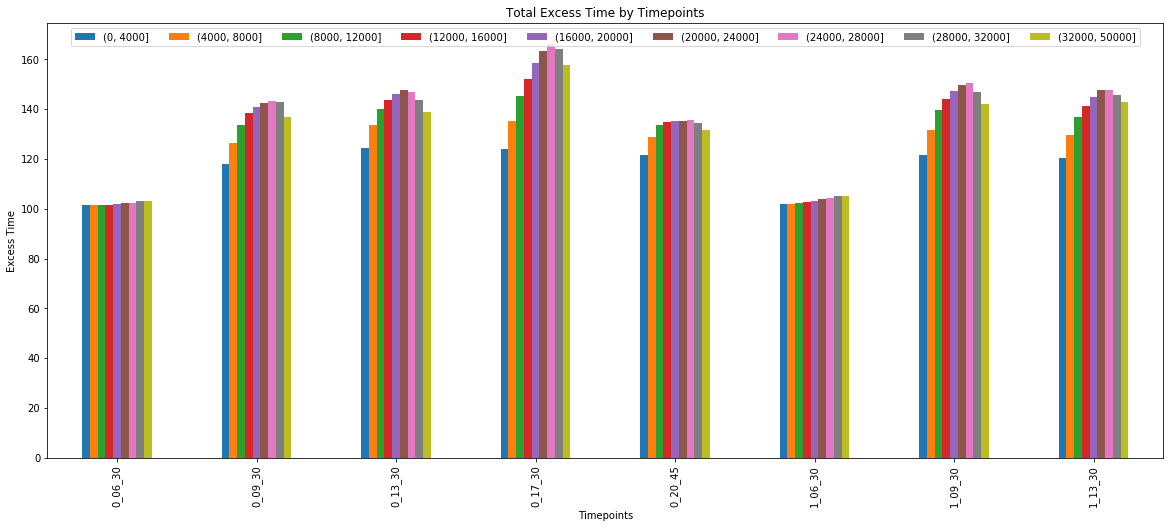

In [21]:
grps_time = df.groupby(["week_time","distCat"])["excessRatio"].mean()
my_plot = grps_time.unstack().plot(kind='bar',title="Total Excess Time by Timepoints",figsize=(20, 8))
my_plot.set_xlabel("Timepoints")
my_plot.set_ylabel("Excess Time")
my_plot.legend(loc=9,ncol=10)
plt.show()

In [ ]:
## Finding categories of time wasted

In [146]:
df["excessRatioCat"] = pd.cut(df["excessRatio"], [100,110,120,150,180,210,250,310])

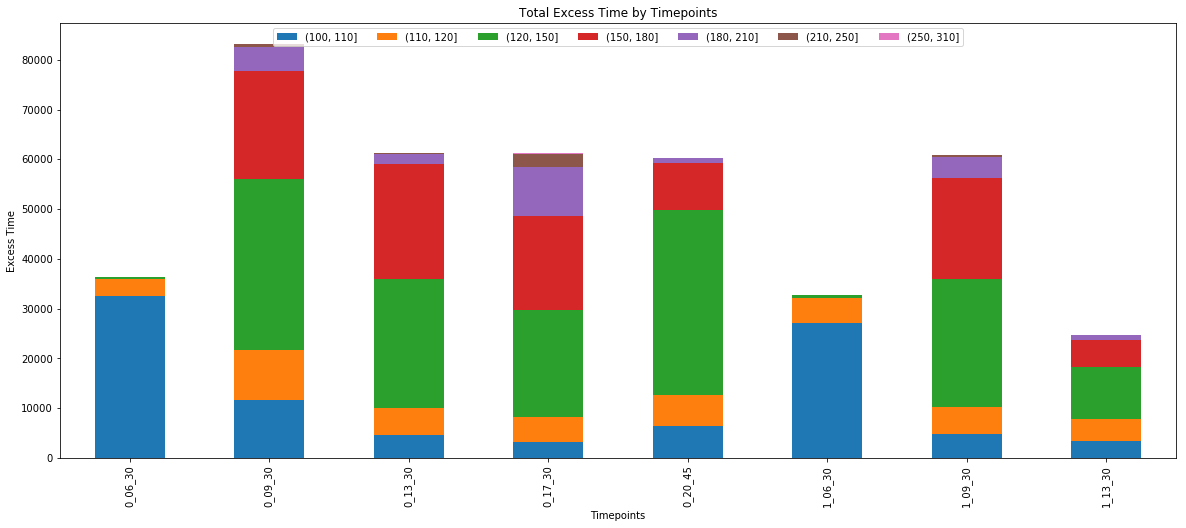

In [159]:
grps_time = df.groupby(["week_time","excessRatioCat"])["excessRatioCat"].count()
my_plot = grps_time.unstack().plot(kind='bar',stacked=True,title="Total Excess Time by Timepoints",figsize=(20, 8))
my_plot.set_xlabel("Timepoints")
my_plot.set_ylabel("Excess Time")
my_plot.legend(loc=9,ncol=10)
plt.show()

## Raw Facts

### Example: 25% percentage area of Delhi which is spending atleast 38% excess time to commute

In [81]:
grps_time = df.groupby(["tFr"])["excessRatio"].mean()
grps_time.quantile([.25,.5,.75,.9,.95])

0.25    112.265779
0.50    128.203402
0.75    142.007894
0.90    148.254128
0.95    150.358077
Name: excessRatio, dtype: float64

In [85]:
grps_time

tFr
8      103.127710
9      106.507093
10     106.065326
36     103.113600
37     105.499132
38     105.818502
39     106.593775
61     104.709152
62     103.236586
63     104.215197
64     104.811973
65     106.965311
66     107.863054
67     107.487463
68     105.952860
90     104.326352
91     104.994616
92     105.020345
93     105.839977
94     106.874709
95     109.068274
96     107.476350
97     106.259315
118    105.600297
119    107.492409
120    106.552401
121    109.930889
122    112.319310
123    109.463942
124    109.044583
          ...    
762    141.011737
763    134.451572
764    146.457852
765    130.356175
766    148.260101
767    147.379380
768    145.722631
769    147.555363
770    147.130864
771    144.826092
772    137.921186
773    138.197589
774    125.423429
788    135.331789
789    139.857879
790    135.549625
791    130.564263
795    149.980096
796    144.684300
797    143.898191
798    139.613386
799    144.072356
800    138.646937
801    129.887790
818   

In [84]:
hex_tiles.columns

Index(['_id', 'geometry', 'properties', 'type'], dtype='object')

### Example: In peak hour of evenings (5:30pm) 25% percentage area of Delhi is spending atleast 67% excess time to commute

In [24]:
grps_time = df[df["week_time"]=="0_17_30"].groupby(["tFr"])["excessRatio"].mean()
grps_time.quantile([.25,.5,.75,.9,.95])

0.25    129.035955
0.50    147.971754
0.75    167.808511
0.90    183.015136
0.95    187.339789
Name: excessRatio, dtype: float64

### Example: In peak hour of evenings (5:30pm) 25% percentage area of Delhi is spending atleast 78% excess time to commute 20kms or more

In [25]:
grps_time = df[(df["week_time"]=="0_17_30") & (df["dist"]>20000)].groupby(["tFr"])["excessRatio"].mean()
grps_time.quantile([.25,.5,.75,.9,.95])

0.25    139.405871
0.50    157.217802
0.75    178.681226
0.90    191.955788
0.95    202.045053
Name: excessRatio, dtype: float64

In [76]:
df[df["excessRatio"]>200]

,_id,dist,dur,durTr,enAdd,enLoc,neDist,stAdd,stLoc,steps,tEn,tFr,timestamp,excessRatio
102072,317_427_1_0_0,12569,1167,2426,"Gurgaon - Delhi Expy, Yawantika Colony, Samalk...","{'lat': 28.5258084, 'lng': 77.1011511}",4,"10, UER II, Sector 24 Dwarka, Dwarka, Delhi, 1...","{'lat': 28.5604293, 'lng': 77.0322908}","[{'dist': 6550, 'dur': 640, 'stLoc': {'lat': 2...",427,317,1491192000,207.883462
105385,344_372_1_0_0,3708,454,1000,"UER II, Bharthal, New Delhi, Delhi 110037, India","{'lat': 28.5437084, 'lng': 77.0668156}",1,"UER II, Sector 25 Dwarka, Dwarka, New Delhi, D...","{'lat': 28.5523951, 'lng': 77.0489463}","[{'dist': 260, 'dur': 37, 'stLoc': {'lat': 28....",372,344,1491192000,220.264317
105409,344_398_1_0_0,7739,1029,2157,"108, Old Delhi Gurgaon Rd, Udyog Vihar, Udyog ...","{'lat': 28.5167569, 'lng': 77.0838481}",3,"UER II, Sector 25 Dwarka, Dwarka, New Delhi, D...","{'lat': 28.5523951, 'lng': 77.0489463}","[{'dist': 260, 'dur': 37, 'stLoc': {'lat': 28....",398,344,1491192000,209.620991
105410,344_427_1_0_0,10913,1008,2140,"Gurgaon - Delhi Expy, Yawantika Colony, Samalk...","{'lat': 28.5258084, 'lng': 77.1011511}",3,"UER II, Sector 25 Dwarka, Dwarka, New Delhi, D...","{'lat': 28.5523951, 'lng': 77.0489463}","[{'dist': 260, 'dur': 37, 'stLoc': {'lat': 28....",427,344,1491192000,212.301587
105457,344_452_1_0_0,15332,1779,3623,"Acharya Shree Tulsi Marg, Arjan Garh, Aya Naga...","{'lat': 28.4814126, 'lng': 77.119063}",6,"UER II, Sector 25 Dwarka, Dwarka, New Delhi, D...","{'lat': 28.5523951, 'lng': 77.0489463}","[{'dist': 260, 'dur': 37, 'stLoc': {'lat': 28....",452,344,1491192000,203.653738
105458,344_481_1_0_0,17306,1924,3878,"356, Acharya Shree Tulsi Marg, Ghitorni, New D...","{'lat': 28.4907417, 'lng': 77.1365891}",6,"UER II, Sector 25 Dwarka, Dwarka, New Delhi, D...","{'lat': 28.5523951, 'lng': 77.0489463}","[{'dist': 260, 'dur': 37, 'stLoc': {'lat': 28....",481,344,1491192000,201.559252
105476,344_424_1_0_0,14986,1865,3745,"A 1/10, Deodar Marg, Block A, Sector 26A, Guru...","{'lat': 28.473086, 'lng': 77.1010319}",7,"UER II, Sector 25 Dwarka, Dwarka, New Delhi, D...","{'lat': 28.5523951, 'lng': 77.0489463}","[{'dist': 260, 'dur': 37, 'stLoc': {'lat': 28....",424,344,1491192000,200.804290
105501,344_450_1_0_0,18378,2051,4123,"Unnamed Road, DLF Phase 5, Sector 54, Gurugram...","{'lat': 28.4490204, 'lng': 77.1183346}",8,"UER II, Sector 25 Dwarka, Dwarka, New Delhi, D...","{'lat': 28.5523951, 'lng': 77.0489463}","[{'dist': 260, 'dur': 37, 'stLoc': {'lat': 28....",450,344,1491192000,201.023891
105622,345_427_1_0_0,13251,1213,2446,"Gurgaon - Delhi Expy, Yawantika Colony, Samalk...","{'lat': 28.5258084, 'lng': 77.1011511}",4,"Dabri - Gurgaon Rd, Sector 23, Dwarka, Delhi, ...","{'lat': 28.5687848, 'lng': 77.0504399}","[{'dist': 222, 'dur': 19, 'stLoc': {'lat': 28....",427,345,1491192000,201.648805
106313,348_513_1_0_0,18866,2644,5523,"102, Anuj Vihar, Delhi Cantonment, Delhi, 1100...","{'lat': 28.5699258, 'lng': 77.1528263}",6,"Galli Number 12, Phase 2, Om Vihar, Nawada, De...","{'lat': 28.6221379, 'lng': 77.0494678}","[{'dist': 9, 'dur': 3, 'stLoc': {'lat': 28.622...",513,348,1491192000,208.888048


## Studying Routes

In [26]:
df["route"] = df["tFr"].map(str)  + "_"+ df["tEn"].map(str)

### 25% of routes face 50% excesstime

In [27]:
df["excessRatio"].quantile([0.5,.75,.9,.95])

0.50    127.969637
0.75    151.065610
0.90    169.758136
0.95    181.348290
Name: excessRatio, dtype: float64

### 25% of routes face 73% excesstime during peak hour - 5:30pm

In [28]:
df[(df["week_time"]=="0_17_30")]["excessRatio"].quantile([0.5,.75,.9,.95])

0.50    151.010661
0.75    174.597094
0.90    195.678765
0.95    208.724049
Name: excessRatio, dtype: float64

### 25% of routes face 78% extra commute time to travel more than 10kms during peak hour - 5:30pm

In [30]:
df[(df["week_time"]=="0_17_30") & (df["dist"]>20000)]["excessRatio"].quantile([0.5,.75,.9,.95])

0.50    160.922235
0.75    183.938118
0.90    204.634041
0.95    218.690614
Name: excessRatio, dtype: float64

### All areas taking 100% excess time to commute a distance of less than equal to 6kms on multiple routes

In [55]:
areas_commute_more_short_dist = df[(df["dspaist"]<6000)].groupby(["tFr"])["excessRatio"].mean()
areas_commute_more_short_dist.sort_values(ascending=False)

tFr
566    151.527341
710    149.978179
568    149.290430
515    149.023916
567    146.235393
707    145.079853
486    143.887480
544    143.306262
543    142.749236
545    142.160271
570    141.720712
403    141.443351
622    140.867942
569    139.880598
597    139.719610
687    139.588223
596    139.554885
542    139.103851
595    139.101029
571    138.888283
656    138.882546
624    138.679731
541    138.559167
734    138.424073
457    138.251868
735    138.226037
539    138.197757
709    138.175033
538    137.856354
766    137.235387
          ...    
273    100.368561
583    100.357855
246    100.315726
68     100.315457
242    100.315027
61     100.254145
277    100.238436
555    100.209490
391    100.187416
62     100.170714
146    100.156250
97     100.143678
582    100.141677
244    100.107673
613    100.106157
274    100.096769
118    100.085023
245    100.070749
63     100.052329
333    100.045662
497    100.044803
474    100.044590
648    100.000000
529    100.000000
611   

## Finding correlation

In [66]:
df_new = df[df["excessRatio"]>150][["dist","excessRatio","timestamp"]]

In [67]:
df_new.shape

(186000, 3)

In [68]:
df_new["distCat"] = pd.cut(df_new["dist"], [0,8000,16000,24000,32000,50000])

In [69]:
def day_time(ts):
    date = pd.to_datetime(ts, unit='s')
    return (str(date.hour+5).zfill(2) + "_"  +str(date.minute+30))

In [70]:
df_new["day_time"] = df_new["timestamp"].apply(day_time)

In [71]:
df_new.columns

Index(['dist', 'excessRatio', 'timestamp', 'distCat', 'day_time'], dtype='object')

In [72]:
df_new = df_new.join(pd.get_dummies(df_new["day_time"]))

In [73]:
df_new = df_new.join(pd.get_dummies(df_new["distCat"]))

In [74]:
df_new.columns

Index(['dist', 'excessRatio', 'timestamp', 'distCat', 'day_time', '06_30',
       '09_30', '13_30', '17_30', '20_45', '(0, 8000]', '(8000, 16000]',
       '(16000, 24000]', '(24000, 32000]', '(32000, 50000]'],
      dtype='object')

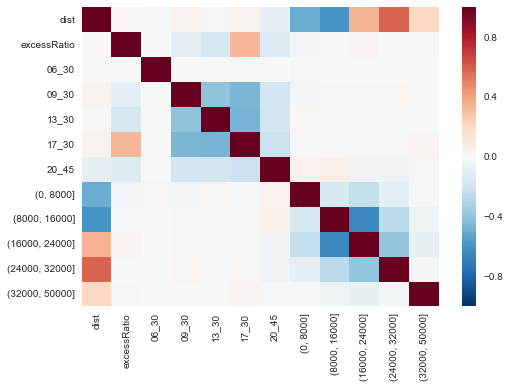

In [75]:
import seaborn as sns
sns.heatmap(df_new.drop(['day_time', 'timestamp',"distCat"], axis=1).corr())
plt.show()